In [1]:
# Imports for this Notebook
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [87]:
df_test = pd.read_csv("data/adult/adult.test", header=None, skiprows=2)

16280

In [240]:
# This file is a CSV, just no CSV extension or headers
# https://archive.ics.uci.edu/ml/datasets/Adult
# https://www.kaggle.com/uciml/adult-census-income#adult.csv
df = pd.read_csv("data/adult/adult.data", header=None)
print("Read {} rows.".format(len(df)))

df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)

df.columns = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education_num',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
    'native_country',
    
    'outcome'
]

# drop row with missing values
missed = ' ?'
drop_indices = df[ (df['workclass'] == missed) | \
                    (df['education'] == missed) | \
                    (df['marital_status'] == missed) | \
                    (df['occupation'] == missed) | \
                    (df['relationship'] == missed) | \
                    (df['race'] == missed) | \
                    (df['sex'] == missed) | \
                    (df['native_country'] == missed)
                  ].index
df.drop(drop_indices , inplace=True)
print("Clean {} rows.".format(len(df)))

Read 32561 rows.
Clean 30162 rows.


In [241]:
df.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,outcome
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Feature Engineering

In [242]:
df["marital_status"] = df["marital_status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
df["marital_status"] = df["marital_status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')

df.drop(labels=["education","relationship","race","native_country"], axis = 1, inplace = True)

In [243]:
# Now encode the feature vector

encode_numeric_zscore(df, 'age')
encode_text_dummy(df, 'workclass')
encode_numeric_zscore(df, 'fnlwgt')
#encode_text_dummy(df, 'education')
encode_numeric_zscore(df, 'education_num')
encode_text_dummy(df, 'marital_status')
encode_text_dummy(df, 'occupation')
#encode_text_dummy(df, 'relationship')
#encode_text_dummy(df, 'race')
encode_text_dummy(df, 'sex')
encode_numeric_zscore(df, 'capital_gain')
encode_numeric_zscore(df, 'capital_loss')
encode_numeric_zscore(df, 'hours_per_week')
#encode_text_dummy(df, 'native_country')

outcomes = encode_text_index(df, 'outcome')
num_classes = len(outcomes)

# display 5 rows
df[0:5]
# This is the numeric feature vector, as it goes to the neural net

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,outcome,workclass- Federal-gov,workclass- Local-gov,workclass- Private,...,occupation- Machine-op-inspct,occupation- Other-service,occupation- Priv-house-serv,occupation- Prof-specialty,occupation- Protective-serv,occupation- Sales,occupation- Tech-support,occupation- Transport-moving,sex- Female,sex- Male
0,0.042795,-1.062704,1.128900,0.146090,-0.218582,-0.077733,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.880274,-1.007855,1.128900,-0.147442,-0.218582,-2.331492,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.033339,0.244689,-0.439731,-0.147442,-0.218582,-0.077733,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1.108677,0.425233,-1.224046,-0.147442,-0.218582,-0.077733,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,-0.794684,1.406635,1.128900,-0.147442,-0.218582,-0.077733,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [244]:
import numpy
from pandas import read_csv
from sklearn.decomposition import PCA
# load data

array_outcome_whole = df[['outcome']].values
array_outcome_whole[array_outcome_whole!=0] = 1
array_outcome_whole[array_outcome_whole==0] = 0

del df['outcome']

X = df.values
Y = array_outcome_whole

print(np.shape(X),np.shape(Y))

(30162, 36) (30162, 1)


In [245]:
import keras.backend as K
K.clear_session()

In [246]:
# Break into X (predictors) & y (prediction)
# x, y = to_xy(df,'outcome')
# x_train, y_train = to_xy(df,'outcome')
# x_test, y_test = to_xy(df1,'outcome')

# Create a test/train split.  25% test
# Split into train/test
# x_train, x_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.25, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25)

In [247]:
x_train.shape, x_test.shape

((22621, 36), (7541, 36))

In [248]:
# Create neural net
model = Sequential()

# Used relu for activation function
model.add(Dense(10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))

# output layer 
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(1,activation = 'sigmoid'))

In [249]:
# TODO:  Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                370       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________


In [250]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.losses = []
        self.accs = []
        self.val_acc = []
        self.val_loss = []
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        acc = logs.get('acc')
        self.losses.append(loss)
        self.accs.append(acc)
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('loss') to the val_acc list
        val_acc = logs.get('val_acc')
        val_loss = logs.get('val_loss')
        self.val_acc.append(val_acc)
        self.val_loss.append(val_loss)

# Create an instance of the history callback
history_cb = LossHistory()

In [251]:
from keras import optimizers

# optimizer defined
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# opt = optimizers.Adam(lr=0.001)


In [252]:
## compile
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [253]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


In [254]:
# model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=1000)
batch_size = 100
epochs = 100
model.fit(x_train,y_train,callbacks=[history_cb],verbose=1,epochs=epochs,batch_size=batch_size,
          validation_data=(x_test,y_test))

Train on 22621 samples, validate on 7541 samples
Epoch 1/100
22621/22621 [==============================] - 1s 23us/step - loss: 0.4602 - acc: 0.7955 - val_loss: 0.3441 - val_acc: 0.8438
Epoch 2/100
22621/22621 [==============================] - 0s 12us/step - loss: 0.3299 - acc: 0.8482 - val_loss: 0.3306 - val_acc: 0.8441
Epoch 3/100
22621/22621 [==============================] - 0s 12us/step - loss: 0.3248 - acc: 0.8496 - val_loss: 0.3269 - val_acc: 0.8476
Epoch 4/100
22621/22621 [==============================] - 0s 12us/step - loss: 0.3219 - acc: 0.8505 - val_loss: 0.3246 - val_acc: 0.8464
Epoch 5/100
22621/22621 [==============================] - 0s 12us/step - loss: 0.3194 - acc: 0.8519 - val_loss: 0.3243 - val_acc: 0.8488
Epoch 6/100
22621/22621 [==============================] - 0s 12us/step - loss: 0.3178 - acc: 0.8540 - val_loss: 0.3236 - val_acc: 0.8468
Epoch 7/100
22621/22621 [==============================] - 0s 12us/step - loss: 0.3183 - acc: 0.8520 - val_loss: 0.3225 - v

22621/22621 [==============================] - 0s 11us/step - loss: 0.3082 - acc: 0.8569 - val_loss: 0.3221 - val_acc: 0.8499
Epoch 60/100
22621/22621 [==============================] - 0s 11us/step - loss: 0.3081 - acc: 0.8557 - val_loss: 0.3225 - val_acc: 0.8509
Epoch 61/100
22621/22621 [==============================] - 0s 14us/step - loss: 0.3079 - acc: 0.8579 - val_loss: 0.3260 - val_acc: 0.8479
Epoch 62/100
22621/22621 [==============================] - 0s 11us/step - loss: 0.3084 - acc: 0.8557 - val_loss: 0.3215 - val_acc: 0.8499
Epoch 63/100
22621/22621 [==============================] - 0s 11us/step - loss: 0.3079 - acc: 0.8566 - val_loss: 0.3223 - val_acc: 0.8486
Epoch 64/100
22621/22621 [==============================] - 0s 14us/step - loss: 0.3079 - acc: 0.8577 - val_loss: 0.3237 - val_acc: 0.8488
Epoch 65/100
22621/22621 [==============================] - 0s 13us/step - loss: 0.3077 - acc: 0.8565 - val_loss: 0.3224 - val_acc: 0.8480
Epoch 66/100
22621/22621 [==============

In [255]:
yhat = model.predict(x_test)
yhat[yhat>0.5] = 1
yhat[yhat<=0.5] = 0
count = 0
yhat_size = np.shape(yhat)[0]

for i in range (yhat_size):
    if yhat[i] != y_test[i]:
        count = count + 1
print("Accuracy is: %s" %(1-count/yhat_size))
print("# of wrongly classified: %s" %(count))

Accuracy is: 0.8485611987800027
# of wrongly classified: 1142


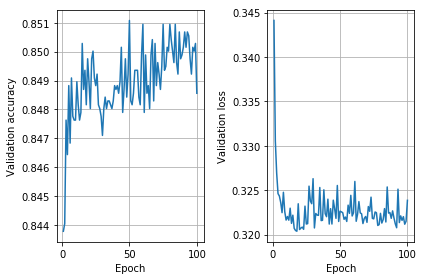

In [256]:
valAcc = history_cb.val_acc
valLoss = history_cb.val_loss
epoch_it = np.arange(1,101)
plt.subplot(121)
plt.plot(epoch_it, valAcc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.tight_layout()
plt.subplot(122)
plt.plot(epoch_it, valLoss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.tight_layout()
plt.show()

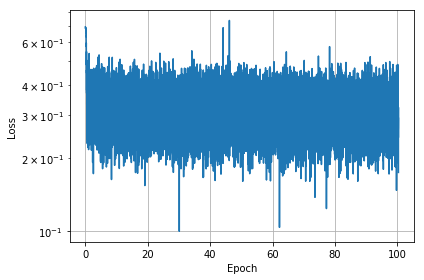

In [257]:
Ls = history_cb.losses
Acc = history_cb.accs
ntr = np.shape(x_train)[0]
epochNum = []
for i in range(len(Ls)):
    epochNum.append(i*100/ntr)

matplotlib.pyplot.semilogy(epochNum, Ls)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

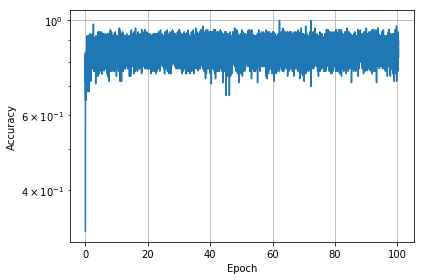

In [258]:
matplotlib.pyplot.semilogy(epochNum, Acc)
# plt.plot(epochNum, Acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
# plt.axis([0.3,3,0.96,1])
plt.show()
